In [2]:
# tools
import pandas as pd
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series

# models
from neuralforecast.auto import NHITS, BiTCN

# forecast
from neuralforecast.core import NeuralForecast

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")

# data

## basic data

* autorregresive features $y_{[:t]}$: `y`
* historic exogenous $x_{[:t]}^{(h)}$: `system_load`

In [3]:
df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/EPF_FR_BE.csv')
df['ds'] = pd.to_datetime(df['ds'])
print(df.head(), "\n")
print(df.tail(), "\n")
print(df.shape, "\n")
print(df["unique_id"].value_counts())

  unique_id                  ds      y  gen_forecast  system_load  week_day
0        FR 2015-01-01 00:00:00  53.48       76905.0      74812.0         3
1        FR 2015-01-01 01:00:00  51.93       75492.0      71469.0         3
2        FR 2015-01-01 02:00:00  48.76       74394.0      69642.0         3
3        FR 2015-01-01 03:00:00  42.27       72639.0      66704.0         3
4        FR 2015-01-01 04:00:00  38.41       69347.0      65051.0         3 

      unique_id                  ds      y  gen_forecast  system_load  \
32155        BE 2016-10-31 19:00:00  65.83       55041.0      59537.0   
32156        BE 2016-10-31 20:00:00  56.11       53535.0      53823.0   
32157        BE 2016-10-31 21:00:00  40.26       49893.0      50622.0   
32158        BE 2016-10-31 22:00:00  38.62       49037.0      49194.0   
32159        BE 2016-10-31 23:00:00  38.65       49094.0      53441.0   

       week_day  
32155         0  
32156         0  
32157         0  
32158         0  
32159        

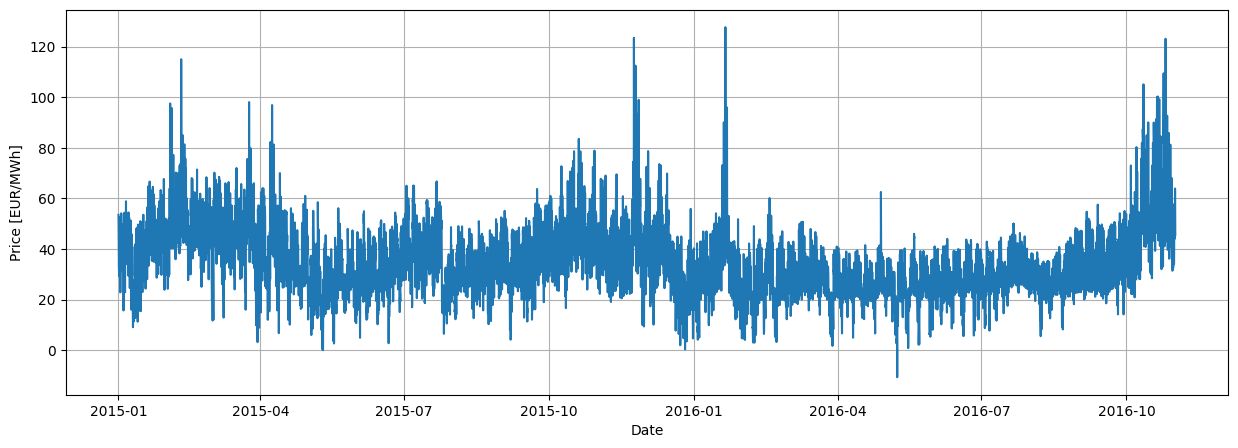

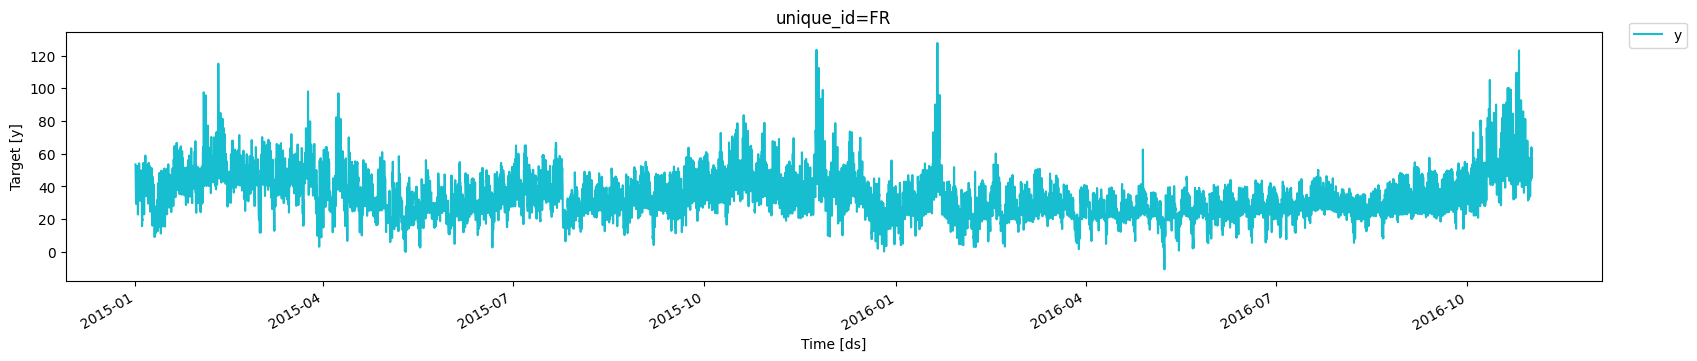

In [7]:
plt.figure(figsize = (15, 5))
plt.plot(df[df["unique_id"] == "FR"]["ds"], df[df["unique_id"] == "FR"]["y"])
plt.xlabel("Date")
plt.ylabel("Price [EUR/MWh]")
plt.grid()
plt.show()

fig = plot_series(df.loc[df["unique_id"] == "FR"])
fig

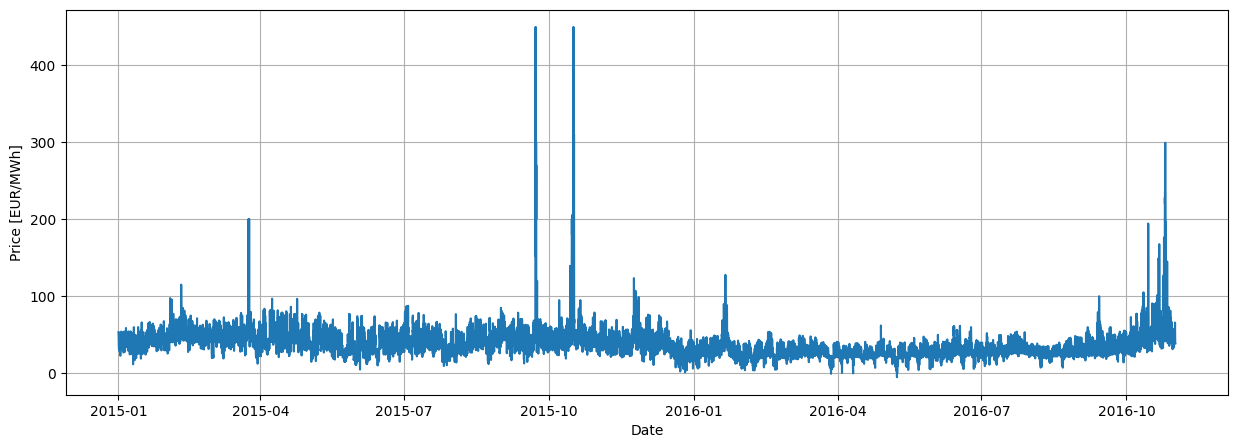

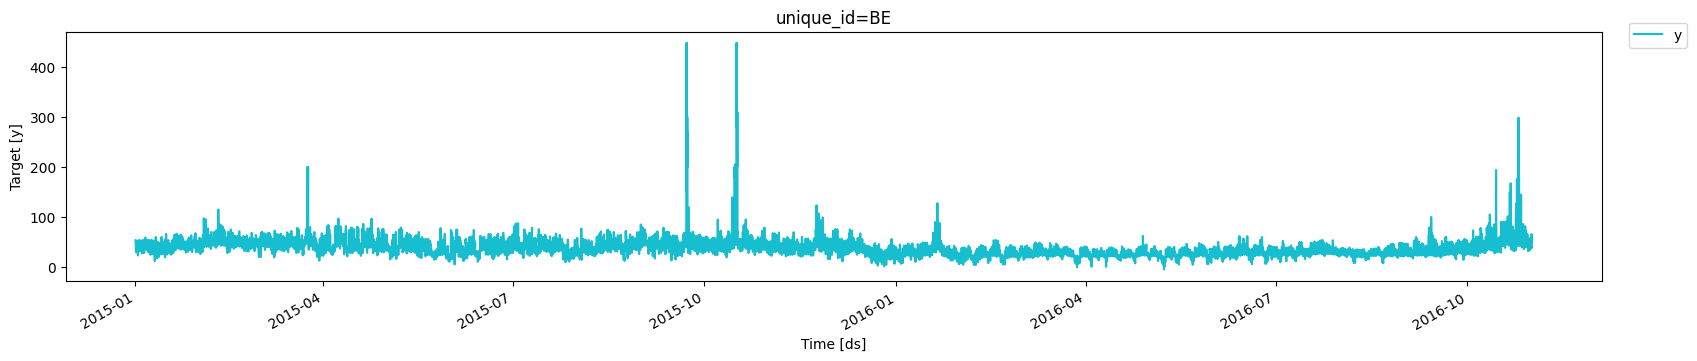

In [8]:
plt.figure(figsize = (15, 5))
plt.plot(df[df["unique_id"] == "BE"]["ds"], df[df["unique_id"] == "BE"]["y"])
plt.xlabel("Date")
plt.ylabel("Price [EUR/MWh]")
plt.grid()
plt.show()

fig = plot_series(df.loc[df["unique_id"] == "BE"])
fig

## static exogenous

* static exogenous $x^{(s)}$

In [9]:
static_df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/EPF_FR_BE_static.csv')
static_df

,unique_id,market_0,market_1
0,FR,1,0
1,BR,0,1


## future exogenous

* future exogenous $x_{[:t+H]}^{(f)}$: `gen_forecast`, `week_day`

In [10]:
futr_df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/EPF_FR_BE_futr.csv')
futr_df['ds'] = pd.to_datetime(futr_df['ds'])
print(futr_df.head(), "\n")
print(futr_df.shape, "\n")
print(futr_df["unique_id"].value_counts(), "\n")

  unique_id                  ds  gen_forecast  week_day
0        FR 2016-11-01 00:00:00       49118.0         1
1        FR 2016-11-01 01:00:00       47890.0         1
2        FR 2016-11-01 02:00:00       47158.0         1
3        FR 2016-11-01 03:00:00       45991.0         1
4        FR 2016-11-01 04:00:00       45378.0         1 

(48, 4) 

unique_id
FR    24
BE    24
Name: count, dtype: int64 



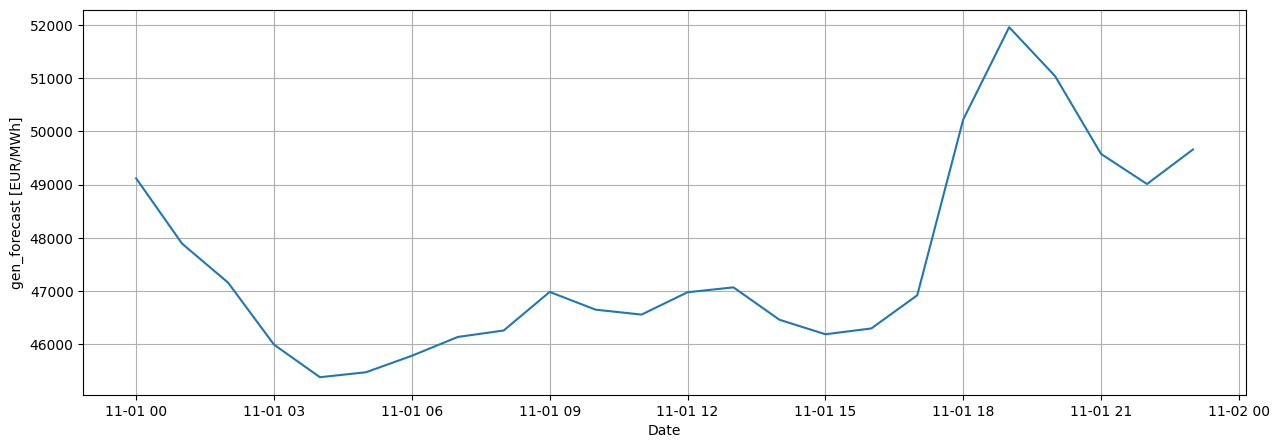

In [11]:
plt.figure(figsize = (15, 5))
plt.plot(futr_df[futr_df["unique_id"] == "FR"]["ds"], futr_df[futr_df["unique_id"] == "FR"]["gen_forecast"])
plt.xlabel("Date")
plt.ylabel("gen_forecast [EUR/MWh]")
plt.grid()
plt.show()

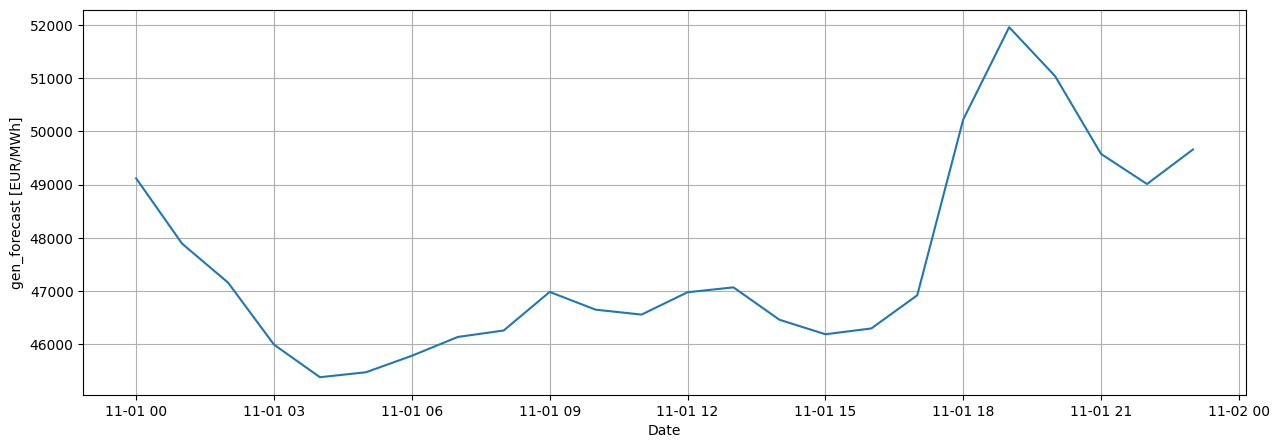

In [12]:
plt.figure(figsize = (15, 5))
plt.plot(futr_df[futr_df["unique_id"] == "BE"]["ds"], futr_df[futr_df["unique_id"] == "BE"]["gen_forecast"])
plt.xlabel("Date")
plt.ylabel("gen_forecast [EUR/MWh]")
plt.grid()
plt.show()

# model training

In [15]:
horizon = 24
nf = NeuralForecast(
    models = [
        NHITS(
            input_size=  5 * horizon,
            h = horizon,
            hist_exog_list=["system_load"],
            stat_exog_list=["market_0", "market_1"],
            futr_exog_list=["gen_forecast", "week_day"],
            scaler_type = "robust",
        ),
        BiTCN(
            input_size = 5 * horizon,
            h = horizon,
            hist_exog_list=["system_load"],
            stat_exog_list=["market_0", "market_1"],
            futr_exog_list=["gen_forecast", "week_day"],
            scaler_type = "robust",
        ),
    ],
    freq = "h",
)
nf.fit(df = df, static_df = static_df)

# model predicting

In [75]:
Y_hat_df = nf.predict(futr_df = futr_df)
print(Y_hat_df)

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

                           ds      NHITS      BiTCN
unique_id                                          
BE        2016-11-01 00:00:00  36.394161  40.228451
BE        2016-11-01 01:00:00  31.969061  36.607925
BE        2016-11-01 02:00:00  31.374901  34.320301
BE        2016-11-01 03:00:00  30.354225  31.782152
BE        2016-11-01 04:00:00  30.672724  30.989100
BE        2016-11-01 05:00:00  31.087416  33.459602
BE        2016-11-01 06:00:00  35.230228  38.312954
BE        2016-11-01 07:00:00  41.574783  42.692329
BE        2016-11-01 08:00:00  43.173431  44.510853
BE        2016-11-01 09:00:00  41.335281  44.559834
BE        2016-11-01 10:00:00  40.204727  42.534519
BE        2016-11-01 11:00:00  37.995689  41.406139
BE        2016-11-01 12:00:00  35.411621  40.771992
BE        2016-11-01 13:00:00  34.372864  39.903778
BE        2016-11-01 14:00:00  35.309013  38.470970
BE        2016-11-01 15:00:00  37.979553  38.177444
BE        2016-11-01 16:00:00  42.892761  41.286716
BE        20

# model result

In [76]:
Y_hat_df = Y_hat_df.reset_index(drop = False)

plot_df_FR = df[df["unique_id"] == "FR"].tail(24*5).reset_index(drop = True)
Y_hat_df_FR = Y_hat_df[Y_hat_df["unique_id"] == "FR"]
plot_df_FR = pd.concat([plot_df_FR, Y_hat_df_FR]).set_index('ds')

plot_df_BE = df[df["unique_id"] == "BE"].tail(24*5).reset_index(drop = True)
Y_hat_df_BE = Y_hat_df[Y_hat_df["unique_id"] == "BE"]
plot_df_BE = pd.concat([plot_df_BE, Y_hat_df_BE]).set_index('ds')

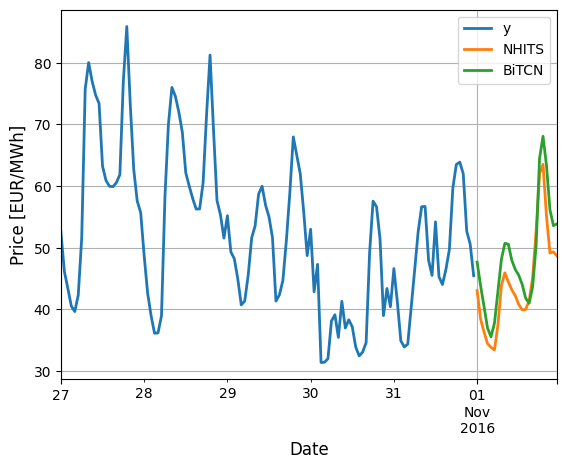

In [79]:
plot_df_FR[['y', 'NHITS', 'BiTCN']].plot(linewidth = 2)
plt.axvline(pd.to_datetime('2016-11-01'), color='red')
plt.ylabel('Price [EUR/MWh]', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid()

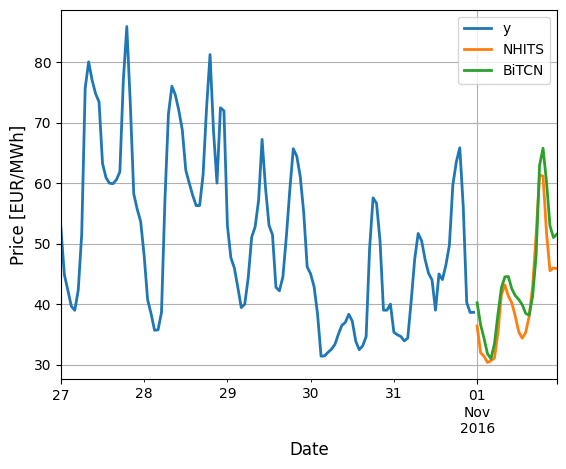

In [80]:
plot_df_BE[['y', 'NHITS', 'BiTCN']].plot(linewidth = 2)
plt.axvline(pd.to_datetime('2016-11-01'), color='red')
plt.ylabel('Price [EUR/MWh]', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid()